<a href="https://colab.research.google.com/github/Gr-30/DL/blob/main/Assign4_Q2_Twitter_114.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Libraries are important and we call them to perform the different actions on our data and for training the models.
- Its a first step to load the library to perform the specific task

In [30]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.regularizers as reg
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Mtech DSE BITS/Sem3/DL/Assignment1/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")

In [4]:
data.columns = ["label", "time", "date", "query", "username", "text"]

#### Five top records of data

In [5]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Five last records of data

In [6]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### Coloumns/features in data

In [7]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

#### Length of data

In [8]:
print('lenght of data is', len(data))

lenght of data is 1599999


#### Shape of data

In [9]:
data.shape

(1599999, 6)

#### Data information

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Data types of all coloumns

In [11]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

#### Checking Null values

In [12]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [13]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [14]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1599999


In [15]:
data=data[['text','label']]

#### Assigning 1 to Positive sentment 4

In [16]:
data['label'][data['label']==4]=1

In [17]:
embeddings = embed(data.text.values)

In [18]:
embeddings.shape

TensorShape([1599999, 128])

####  Separating input feature and label

In [19]:
X=embeddings.numpy()
y=data.label

#### Preparing the input features for training 

#### Separating the 70% data for training data and 30% for testing data

As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 70% tweets will be used in the training 
- 20% tweets will be used to test the performance of the model.

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [21]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', Y_train.shape)
print('Y_test: ', Y_test.shape)

X_train:  (1279999, 128)
X_test:  (320000, 128)
Y_train:  (1279999,)
Y_test:  (320000,)


In [22]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(inputs)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

# Model compilation

In [23]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy']) 
print('Model summary')
model.summary() 

Model summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


In [24]:
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.2, callbacks=[callback])# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.5891 - accuracy: 0.7005 - val_loss: 0.5713 - val_accuracy: 0.7121
Epoch 2/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5748 - accuracy: 0.7092 - val_loss: 0.5772 - val_accuracy: 0.7051
Epoch 3/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5735 - accuracy: 0.7098 - val_loss: 0.5742 - val_accuracy: 0.7088
Epoch 4/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.5731 - accuracy: 0.7095 - val_loss: 0.5738 - val_accuracy: 0.7095
Epoch 00004: early stopping
Training finished !!


#### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

In [25]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

10000/10000 [==============================] - 14s 1ms/step - loss: 0.5741 - accuracy: 0.7102


In [26]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.71


In [27]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



confusion matrix


[[122299  37742]
 [ 54996 104963]]




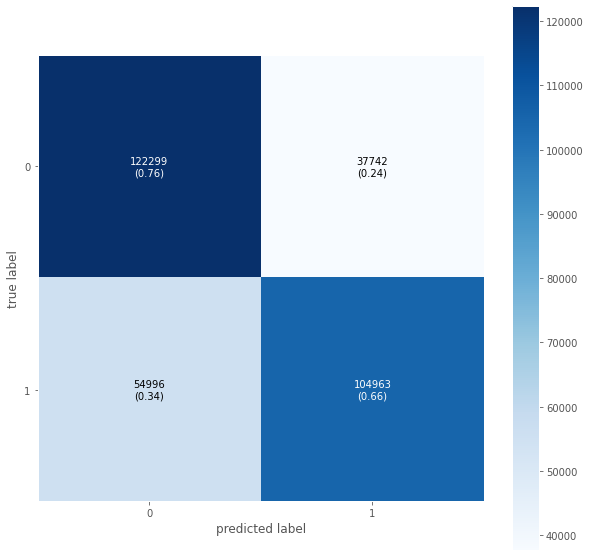

In [28]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE

In [31]:
print(roc_auc_score(Y_test, y_pred))

0.7101799142895483


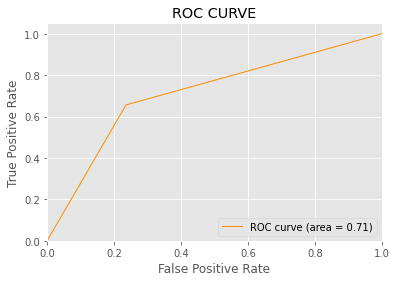

In [29]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()